# License

    IPython notebook for running a trivial OpenCL program
    Copyright (C) 2015, 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import os
import numpy as np
import pyopencl as cl

from matplotlib import pyplot as plt

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

In [2]:
#Determine which GPU to use
os.environ["PYOPENCL_CTX"] = "1"

#Create OpenCL context
cl_ctx = cl.create_some_context()

print("Using ", cl_ctx.devices[0].name)

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

Using  Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz


In [3]:
%%cl_kernel 
__kernel void addKernel(__global float *c, __global const float *a, __global const float *b) {
  int gid = get_global_id(0);
  c[gid] = a[gid] + b[gid];
}

/home/ubuntu/.local/lib/python3.6/site-packages/pyopencl/cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz' on 'Intel(R) OpenCL' at 0x34e1a28> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <addKernel> was successfully vectorized (8)
Done.
  warn(text, CompilerWarning)
/home/ubuntu/.local/lib/python3.6/site-packages/pyopencl/cffi_cl.py:1517: CompilerWarning: From-binary build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz' on 'Intel(R) OpenCL' at 0x34e1a28> succeeded, but said:

Device build started
Device build done
Reload Program Binary Object.
  warn(text, CompilerWarning)


In [4]:
#Size of our test
n = 50

#Create test input / output data
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)
c = np.empty_like(a)

#Upload data to the device
mf = cl.mem_flags
a_g = cl.Buffer(cl_ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
b_g = cl.Buffer(cl_ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)

#Allocate output data
c_g = cl.Buffer(cl_ctx, mf.WRITE_ONLY, a.nbytes)

#Execute program on device
addKernel(cl_queue, a.shape, None, c_g, a_g, b_g)

#Copy data from device to host
cl.enqueue_copy(cl_queue, c, c_g)

In [5]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [1.211883   0.3531082  1.272627   1.2981818  0.8025591  1.2351028
 1.0698063  1.1386272  0.787304   0.59525776 0.9456336  1.0710963
 1.1517982  1.388929   0.590118   0.1644391  0.4499684  1.5216289
 0.36628848 1.3580315  1.4298701  1.3818597  0.94828445 0.20065331
 1.3686972  0.39424512 1.2512407  0.4778268  1.1249628  1.3228875
 1.0745852  0.38970786 1.4940244  1.3092501  0.36736098 1.05302
 1.4209452  0.18347843 0.77353394 1.2953421  1.1006455  0.71949565
 0.7714161  1.2098495  0.74274457 1.0255191  1.3798103  0.89217937
 1.0537128  1.198462  ]
Ref =  [1.211883   0.3531082  1.272627   1.2981818  0.8025591  1.2351028
 1.0698063  1.1386272  0.787304   0.59525776 0.9456336  1.0710963
 1.1517982  1.388929   0.590118   0.1644391  0.4499684  1.5216289
 0.36628848 1.3580315  1.4298701  1.3818597  0.94828445 0.20065331
 1.3686972  0.39424512 1.2512407  0.4778268  1.1249628  1.3228875
 1.0745852  0.38970786 1.4940244  1.3092501  0.36736098 1.05302
 1.4209452  0.18347843 0.77353394 1.29

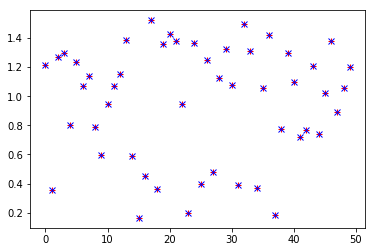

In [6]:
plt.figure()
plt.plot(c, '+r')
plt.plot(c_ref, 'xb')